# Setup - imports


In [17]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from diffusers import AutoencoderKL
from typing import Union

# Import model from stable diffusion

In [18]:
# Specify the directory containing the model files
model_directory = "../checkpoints/stable-diffusion-2/vae/"  # Update this path to where your files are located

# Load the model
vae = AutoencoderKL.from_pretrained(model_directory)

# Now you can use the VAE for encoding and decoding images as described previously
vae.eval()


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

# Preprocess image

In [19]:
def preprocess_image(input_image: Union[Image.Image, torch.Tensor], resize_to: (int, int) = (800, 800)):
    """
    Encodes an image to its latent representation using the MarigoldPipeline.

    Args:
        pipeline (MarigoldPipeline): The MarigoldPipeline instance.
        input_image (Union[Image.Image, torch.Tensor]): The input image to encode.

    Returns:
        torch.Tensor: The latent representation of the image.
    """
    if isinstance(input_image, Image.Image):
        input_image = input_image.convert("RGB")
        #resize to 600x600
        input_image = input_image.resize(resize_to)
        rgb = pil_to_tensor(input_image)
        rgb = rgb.unsqueeze(0)  # [1, rgb, H, W]
    elif isinstance(input_image, torch.Tensor):
        rgb = input_image
    else:
        raise TypeError(f"Unknown input type: {type(input_image) = }")
    
    rgb_norm = rgb / 255.0 * 2.0 - 1.0  # [0, 255] -> [-1, 1]
    return rgb_norm

# Encode Decode with vae

In [11]:
def encode_decode_image(image, model):
    with torch.no_grad():
        encoded = model.encode(image).latent_dist.sample()  # Encode to latent representation
        decoded = model.decode(encoded).sample  # Decode back to image
    return decoded


# Visualization

In [20]:
# Visualize the original and reconstructed images
def visualize_reconstruction(original, reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original image
    axs[0].imshow(np.transpose(original.squeeze().cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    # Reconstructed image
    axs[1].imshow(np.transpose(reconstructed.squeeze().cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    axs[1].set_title('Reconstructed Image')
    axs[1].axis('off')
    
    plt.show()


## Example 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17510068..1.1004736].


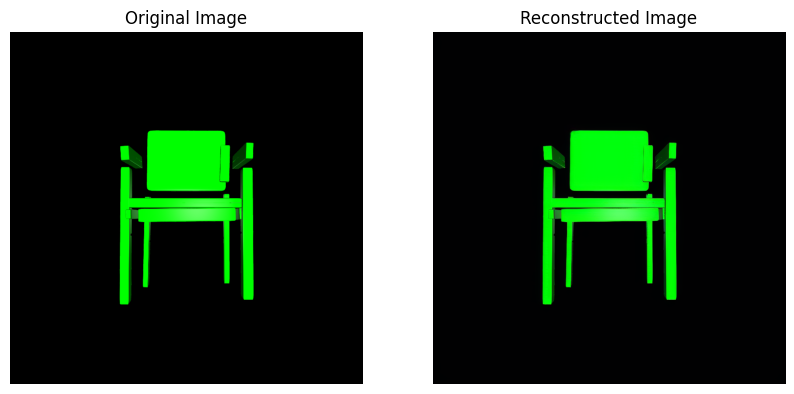

In [13]:
# Example usage
#input_image = Image.open("/Users/cmazzoleni/Documents/GitHub/PrimitiveDifformation/Marigold/input/in-the-wild_example/example_5_pred_colored.png")
input_image = Image.open("/Users/cmazzoleni/Documents/GitHub/CuboidAbstractionViaSeg/data/dataset/dataset_v2_1508/cuboid_front/1a6f615e8b1b5ae4dbbc9440457e303e_complete.png")
pipeline = vae  # Assuming 'vae' is your model

input_image = preprocess_image(input_image)

# Decode the latent representation to get the reconstructed image
reconstructed_image = encode_decode_image(input_image, vae)

# Visualize the original and reconstructed images
visualize_reconstruction(input_image, reconstructed_image)

## Example 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06960833..1.1265676].


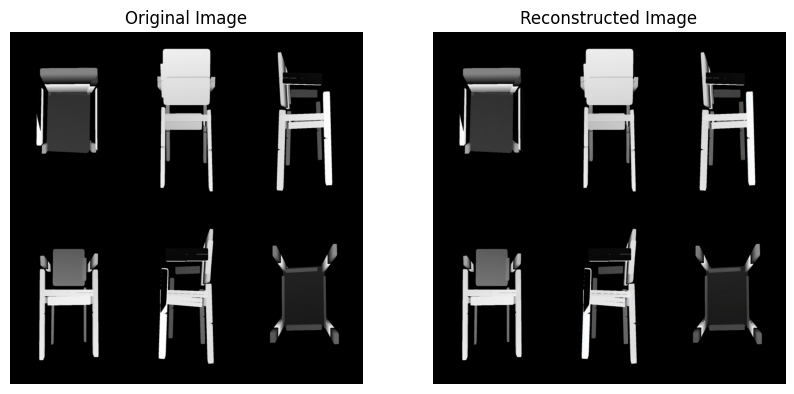

In [21]:
input_image = Image.open("../data/dataset/dataset_v2_1508/cubemap_cuboid_depth/1a6f615e8b1b5ae4dbbc9440457e303e_cubemap.png")
pipeline = vae  # Assuming 'vae' is your model

input_image = preprocess_image(input_image, resize_to=(800, 800))

# Decode the latent representation to get the reconstructed image
reconstructed_image = encode_decode_image(input_image, vae)

# Visualize the original and reconstructed images
visualize_reconstruction(input_image, reconstructed_image)